In [1]:
!pip install xgboost
!pip install sklearn
!pip install hyperopt
!pip install preprocess_features
!pip install -U seaborn

ERROR: Could not find a version that satisfies the requirement preprocess_features (from versions: none)
ERROR: No matching distribution found for preprocess_features


Requirement already up-to-date: seaborn in c:\users\18482\anaconda3\lib\site-packages (0.11.2)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import xgboost as xgb
from xgboost.sklearn import (XGBClassifier, XGBRegressor)

from sklearn.metrics import (r2_score,
                            mean_squared_error,
                            median_absolute_error,
                            roc_auc_score,
                            auc,
                            classification_report,
                            confusion_matrix,
                            roc_curve)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import (mutual_info_classif,
                                       mutual_info_regression)
from sklearn.preprocessing import (OneHotEncoder,
                                  StandardScaler,
                                  LabelEncoder,
                                  label_binarize)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import (KFold,
                                    train_test_split)

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set_style('whitegrid')

### Load Data

In [5]:
Test = pd.read_csv("Test_Dataset.csv")
Train = pd.read_csv("Training_Dataset.csv")

In [6]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6298 entries, 0 to 6297
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ListingID             6298 non-null   int64  
 1   SellerCity            6298 non-null   object 
 2   SellerIsPriv          6298 non-null   bool   
 3   SellerListSrc         6296 non-null   object 
 4   SellerName            6298 non-null   object 
 5   SellerRating          6298 non-null   float64
 6   SellerRevCnt          6298 non-null   int64  
 7   SellerState           6298 non-null   object 
 8   SellerZip             6296 non-null   float64
 9   VehBodystyle          6298 non-null   object 
 10  VehCertified          6298 non-null   bool   
 11  VehColorExt           6225 non-null   object 
 12  VehColorInt           5570 non-null   object 
 13  VehDriveTrain         5897 non-null   object 
 14  VehEngine             5937 non-null   object 
 15  VehFeats             

In [7]:
Train=Train.set_index('ListingID')

In [8]:
Train.head()

,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehBodystyle,VehCertified,...,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehType,VehTransmission,VehYear,Vehicle_Trim,Dealer_Listing_Price
ListingID,,,,,,,,,,,,,,,,,,,,,
3287,Warren,False,Inventory Command Center,Prime Motorz,5.0,32,MI,48091.0,SUV,False,...,Jeep,39319.0,Grand Cherokee,Fair Price,NaN,Used,Automatic 8-Speed,2015,High Altitude,30990.0
3920,Fargo,False,Cadillac Certified Program,Gateway Chevrolet Cadillac,4.8,1456,ND,58103.0,SUV,True,...,Cadillac,30352.0,XT5,Good Deal,Come take a look at our great pre-owned invent...,Used,NaN,2017,NaN,34860.0
4777,Waukesha,False,Jeep Certified Program,Wilde Chrysler Jeep Dodge Ram &amp; Subaru,4.8,1405,WI,53186.0,SUV,True,...,Jeep,38957.0,Grand Cherokee,Good Deal,Backed by a rigorous 125-point inspection by f...,Used,8-Speed Automatic w/OD,2015,Laredo,23249.0
6242,Wentzville,False,Inventory Command Center,Century Dodge Chrysler Jeep RAM,4.4,21,MO,63385.0,SUV,False,...,Jeep,20404.0,Grand Cherokee,Good Deal,Drop by to see us and you will quickly see how...,Used,Automatic,2018,Limited,31977.0
7108,Fayetteville,False,HomeNet Automotive,Superior Buick GMC of Fayetteville,3.7,74,AR,72703.0,SUV,False,...,Cadillac,19788.0,XT5,Good Deal,"Luxury, Exterior Parking Camera Rear, Front Du...",Used,8-Speed Automatic,2018,Luxury,33495.0


In [9]:
Train.columns = Train.columns.str.lower()

In [10]:
Train.columns

Index(['sellercity', 'sellerispriv', 'sellerlistsrc', 'sellername',
       'sellerrating', 'sellerrevcnt', 'sellerstate', 'sellerzip',
       'vehbodystyle', 'vehcertified', 'vehcolorext', 'vehcolorint',
       'vehdrivetrain', 'vehengine', 'vehfeats', 'vehfuel', 'vehhistory',
       'vehlistdays', 'vehmake', 'vehmileage', 'vehmodel', 'vehpricelabel',
       'vehsellernotes', 'vehtype', 'vehtransmission', 'vehyear',
       'vehicle_trim', 'dealer_listing_price'],
      dtype='object')

## Separate Dependent and Independent Variables

### Not necessary, but I want to split the dependent and independent variable apart to inspect the data

In [11]:
y = Train[['vehicle_trim', 'dealer_listing_price']]
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6298 entries, 3287 to 8620012
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vehicle_trim          5893 non-null   object 
 1   dealer_listing_price  6246 non-null   float64
dtypes: float64(1), object(1)
memory usage: 147.6+ KB


In [12]:
y.isna().sum()

vehicle_trim            405
dealer_listing_price     52
dtype: int64

In [13]:
y.head()

,vehicle_trim,dealer_listing_price
ListingID,,
3287,High Altitude,30990.0
3920,NaN,34860.0
4777,Laredo,23249.0
6242,Limited,31977.0
7108,Luxury,33495.0


In [14]:
x = Train.drop(y.columns, axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6298 entries, 3287 to 8620012
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sellercity       6298 non-null   object 
 1   sellerispriv     6298 non-null   bool   
 2   sellerlistsrc    6296 non-null   object 
 3   sellername       6298 non-null   object 
 4   sellerrating     6298 non-null   float64
 5   sellerrevcnt     6298 non-null   int64  
 6   sellerstate      6298 non-null   object 
 7   sellerzip        6296 non-null   float64
 8   vehbodystyle     6298 non-null   object 
 9   vehcertified     6298 non-null   bool   
 10  vehcolorext      6225 non-null   object 
 11  vehcolorint      5570 non-null   object 
 12  vehdrivetrain    5897 non-null   object 
 13  vehengine        5937 non-null   object 
 14  vehfeats         6023 non-null   object 
 15  vehfuel          6296 non-null   object 
 16  vehhistory       6097 non-null   object 
 17  vehlistd

In [15]:
x.isna().sum()

sellercity           0
sellerispriv         0
sellerlistsrc        2
sellername           0
sellerrating         0
sellerrevcnt         0
sellerstate          0
sellerzip            2
vehbodystyle         0
vehcertified         0
vehcolorext         73
vehcolorint        728
vehdrivetrain      401
vehengine          361
vehfeats           275
vehfuel              2
vehhistory         201
vehlistdays          2
vehmake              0
vehmileage           2
vehmodel             0
vehpricelabel      285
vehsellernotes     243
vehtype              0
vehtransmission    197
vehyear              0
dtype: int64

## Explore, Clean, Transform, And Engineer Features

In [16]:
y.head()

,vehicle_trim,dealer_listing_price
ListingID,,
3287,High Altitude,30990.0
3920,NaN,34860.0
4777,Laredo,23249.0
6242,Limited,31977.0
7108,Luxury,33495.0


In [17]:
y['vehicle_trim'].value_counts()

Limited                             1912
Premium Luxury                       747
Laredo                               704
Luxury                               645
Overland                             381
Altitude                             325
Summit                               242
Trailhawk                            178
Base                                 159
Platinum                             131
High Altitude                         86
SRT                                   76
Luxury FWD                            53
FWD                                   49
Laredo E                              47
Premium Luxury FWD                    35
Trackhawk                             30
Sterling Edition                      26
Luxury AWD                            22
Platinum AWD                          13
Premium Luxury AWD                     9
75th Anniversary                       8
Limited 75th Anniversary Edition       5
Upland                                 3
SRT Night       

### We need to clean up the value counts dispersion, as SRT and SRT NIGHT could technically be an non-distinguishable feature that wouldn't fit the model we are trying to build. 
### Same goes for Limited and Limited X.

In [18]:
# Check which makes have "Luxury" in the trim
Train.loc[y['vehicle_trim'].str.lower().str.contains('luxury') == True, 'vehmake'].value_counts()

Cadillac    1511
Name: vehmake, dtype: int64

In [19]:
# Check which make have "Limited" in the trim
Train.loc[y['vehicle_trim'].str.lower().str.contains('limited') == True, 'vehmake'].value_counts()

Jeep    1920
Name: vehmake, dtype: int64

In [20]:
# Check which makes have "Laredo" in the trim
Train.loc[y['vehicle_trim'].str.lower().str.contains('laredo') == True, 'vehmake'].value_counts()

Jeep    751
Name: vehmake, dtype: int64

In [21]:
# Check which makes have "FWD" in the trim
Train.loc[y['vehicle_trim'].str.lower().str.contains('fwd') == True, 'vehmake'].value_counts()

Cadillac    137
Name: vehmake, dtype: int64

In [22]:
# Check which makes have "AWD" in the trim
Train.loc[y['vehicle_trim'].str.lower().str.contains('awd') == True, 'vehmake'].value_counts()

Cadillac    44
Name: vehmake, dtype: int64

In [23]:
# Check what makes exist
Train['vehmake'].value_counts()

Jeep        4199
Cadillac    2099
Name: vehmake, dtype: int64

In [24]:
Train.groupby('vehmake')['vehicle_trim'].value_counts()

vehmake   vehicle_trim                    
Cadillac  Premium Luxury                       747
          Luxury                               645
          Base                                 159
          Platinum                             131
          Luxury FWD                            53
          FWD                                   49
          Premium Luxury FWD                    35
          Luxury AWD                            22
          Platinum AWD                          13
          Premium Luxury AWD                     9
Jeep      Limited                             1912
          Laredo                               704
          Overland                             381
          Altitude                             325
          Summit                               242
          Trailhawk                            178
          High Altitude                         86
          SRT                                   76
          Laredo E                     

### Clean up vehicle_makes

Looking at how these trims are distributed, we are going to clean this up a bit.  First, let's actually separate the data into 2 data set....JEEP and CADILLAC.

In [25]:
Cadillac = Train[Train['vehmake'] == 'Cadillac']
Cadillac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2099 entries, 3920 to 8617378
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            2099 non-null   object 
 1   sellerispriv          2099 non-null   bool   
 2   sellerlistsrc         2099 non-null   object 
 3   sellername            2099 non-null   object 
 4   sellerrating          2099 non-null   float64
 5   sellerrevcnt          2099 non-null   int64  
 6   sellerstate           2099 non-null   object 
 7   sellerzip             2099 non-null   float64
 8   vehbodystyle          2099 non-null   object 
 9   vehcertified          2099 non-null   bool   
 10  vehcolorext           2072 non-null   object 
 11  vehcolorint           1782 non-null   object 
 12  vehdrivetrain         1925 non-null   object 
 13  vehengine             1929 non-null   object 
 14  vehfeats              1863 non-null   object 
 15  vehfuel        

In [26]:
Jeep = Train[Train['vehmake'] == 'Jeep']
Jeep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4199 entries, 3287 to 8620012
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            4199 non-null   object 
 1   sellerispriv          4199 non-null   bool   
 2   sellerlistsrc         4197 non-null   object 
 3   sellername            4199 non-null   object 
 4   sellerrating          4199 non-null   float64
 5   sellerrevcnt          4199 non-null   int64  
 6   sellerstate           4199 non-null   object 
 7   sellerzip             4197 non-null   float64
 8   vehbodystyle          4199 non-null   object 
 9   vehcertified          4199 non-null   bool   
 10  vehcolorext           4153 non-null   object 
 11  vehcolorint           3788 non-null   object 
 12  vehdrivetrain         3972 non-null   object 
 13  vehengine             4008 non-null   object 
 14  vehfeats              4160 non-null   object 
 15  vehfuel        

### Cadillac

Now, we are going to clean the 'vehicle_trim' column by grouping similar trims together.

For Cadillac, we will keep:

    - Premium = Premium Luxury, Premium Luxury FWD, Premium Luxury AWD
    - Luxury = Luxury, Luxury FWD, Luxury AWD
    - Base = Base
    - Platinum = Platinum, Platinum AWD

The remaining trim "FWD" will be dropped, as it is merely 2% of observation and isn't actually a trim package, but rather a type of Drive Train.

In [27]:
Cadillac['vehicle_trim'].value_counts()

Premium Luxury        747
Luxury                645
Base                  159
Platinum              131
Luxury FWD             53
FWD                    49
Premium Luxury FWD     35
Luxury AWD             22
Platinum AWD           13
Premium Luxury AWD      9
Name: vehicle_trim, dtype: int64

In [28]:
Cadillac.loc[Cadillac['vehicle_trim'].str.lower().str.contains('premium') == True, 'vehicle_trim'] = 'premium'
Cadillac.loc[Cadillac['vehicle_trim'].str.lower().str.contains('luxury') == True, 'vehicle_trim'] = 'luxury'
Cadillac.loc[Cadillac['vehicle_trim'].str.lower().str.contains('base') == True, 'vehicle_trim'] = 'base'
Cadillac.loc[Cadillac['vehicle_trim'].str.lower().str.contains('platinum') == True, 'vehicle_trim'] = 'platinum'

In [29]:
Cadillac['vehicle_trim'].value_counts()

premium     791
luxury      720
base        159
platinum    144
FWD          49
Name: vehicle_trim, dtype: int64

In [30]:
Cadillac = Cadillac[Cadillac['vehicle_trim'] != 'FWD']
Cadillac['vehicle_trim'].value_counts()

premium     791
luxury      720
base        159
platinum    144
Name: vehicle_trim, dtype: int64

### Jeep

Just like we did for Cadillac, we will remove/consolidate the categories into the following buckets:

   - Limited = Limited, Limited 75th Anniversary Edition, Limited 75th Anniversary, Limited X
   - Laredo = Laredo, Laredo E
   - SRT = SRT, SRT Night
   
The rest of the trims, we will remove from consideration for this analysis

NOTE:  This "bucketing" choice of action is the highest risk within the analysis.  By ruling out the "75th Anniversary" as a deciding factor, we would need to augment the analysis all over again AT THIS POINT IN TIME. 


In [31]:
Jeep.loc[Jeep['vehicle_trim'].str.lower().str.contains('limited') == True, 'vehicle_trim'] = 'limited'
Jeep.loc[Jeep['vehicle_trim'].str.lower().str.contains('laredo') == True, 'vehicle_trim'] = 'laredo'
Jeep.loc[Jeep['vehicle_trim'].str.lower().str.contains('srt') == True, 'vehicle_trim'] = 'srt'

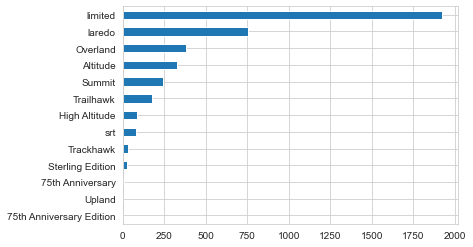

In [32]:
Jeep['vehicle_trim'].value_counts().sort_values().plot.barh();

In [33]:
keep_trims = ['limited','laredo','overland','altitude','summit','trailhawk','high altitude','srt','trackhawk']
Jeep = Jeep.loc[Jeep['vehicle_trim'].str.lower().isin(keep_trims),:] 
Jeep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3992 entries, 3287 to 8620012
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            3992 non-null   object 
 1   sellerispriv          3992 non-null   bool   
 2   sellerlistsrc         3990 non-null   object 
 3   sellername            3992 non-null   object 
 4   sellerrating          3992 non-null   float64
 5   sellerrevcnt          3992 non-null   int64  
 6   sellerstate           3992 non-null   object 
 7   sellerzip             3990 non-null   float64
 8   vehbodystyle          3992 non-null   object 
 9   vehcertified          3992 non-null   bool   
 10  vehcolorext           3966 non-null   object 
 11  vehcolorint           3697 non-null   object 
 12  vehdrivetrain         3933 non-null   object 
 13  vehengine             3969 non-null   object 
 14  vehfeats              3976 non-null   object 
 15  vehfuel        

In [34]:
Jeep['vehicle_trim'].value_counts()

limited          1920
laredo            751
Overland          381
Altitude          325
Summit            242
Trailhawk         178
High Altitude      86
srt                79
Trackhawk          30
Name: vehicle_trim, dtype: int64

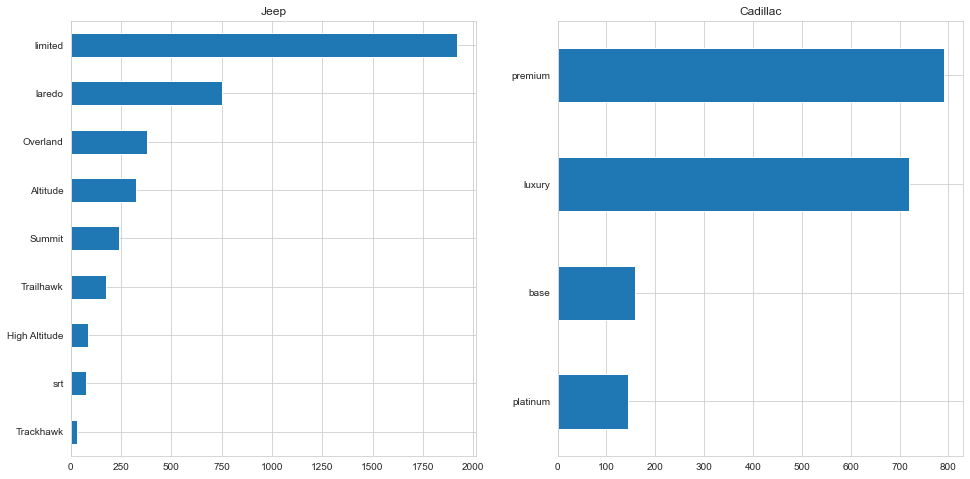

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
Jeep['vehicle_trim'].value_counts().sort_values().plot.barh(ax=axes[0])
axes[0].set_title('Jeep')
Cadillac['vehicle_trim'].value_counts().sort_values().plot.barh(ax=axes[1])
axes[1].set_title('Cadillac')
fig.savefig('trim_counts.png');

In [36]:
y['dealer_listing_price'].isna().sum()

52

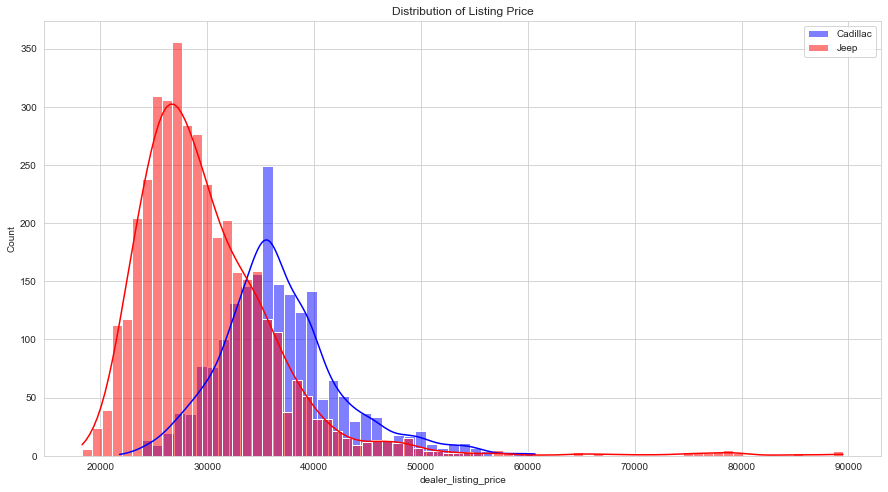

In [37]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(Cadillac['dealer_listing_price'], kde=True, color='blue',ax=ax, label='Cadillac')
sns.histplot(Jeep['dealer_listing_price'], kde=True, color='red', ax=ax, label='Jeep')
ax.legend()
ax.set_title('Distribution of Listing Price');

### Log Transform to display the look of normal distribution across both data sets

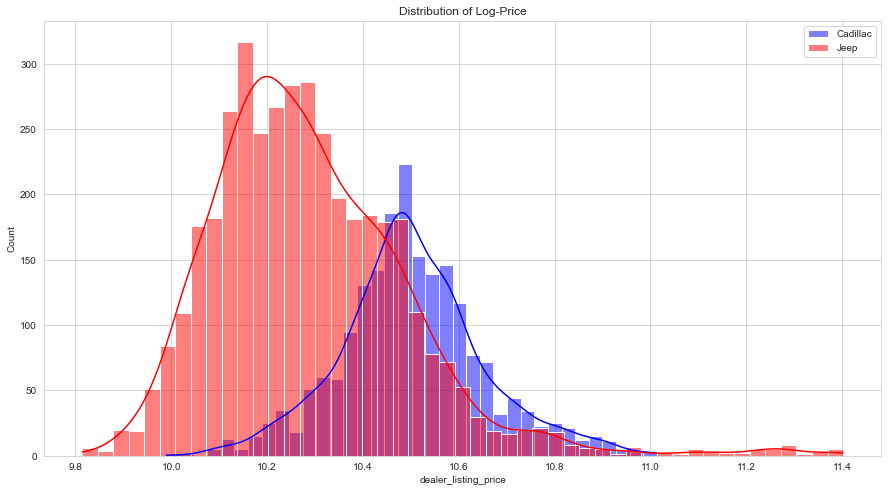

In [38]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(np.log(Cadillac['dealer_listing_price']), kde=True, color='blue',ax=ax, label='Cadillac')
sns.histplot(np.log(Jeep['dealer_listing_price']), kde=True, color='red',ax=ax, label='Jeep')
ax.legend()
ax.set_title('Distribution of Log-Price');

### This confirms that Log Transform DOES normalize the distribution of data.  As you can see, the data tails off at the end LESS than when using the raw data.

### Cadillac Data

Text(0.5, 0.98, 'Cadillac')

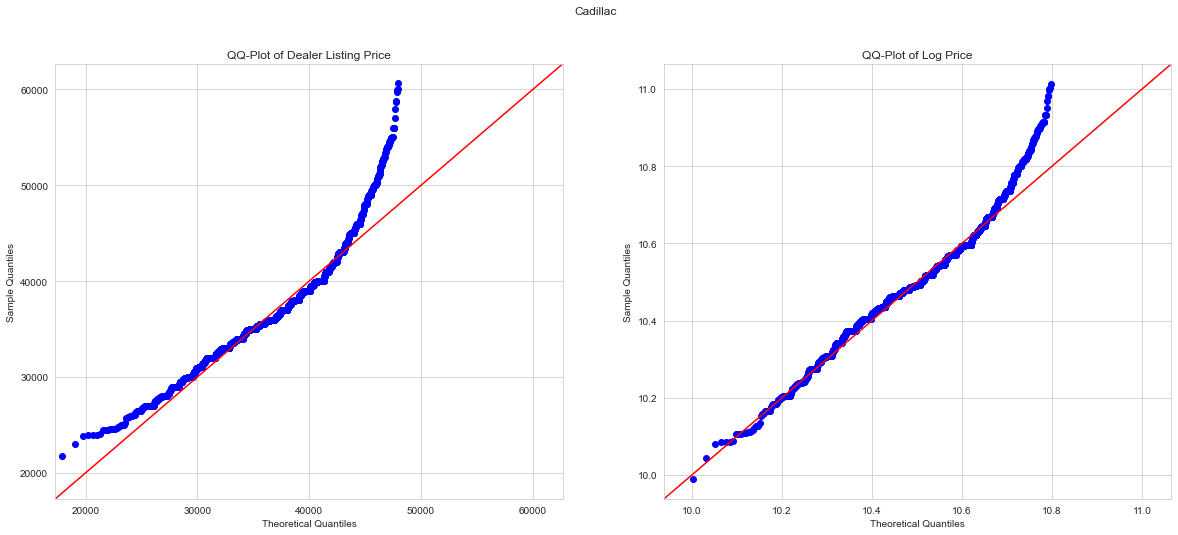

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
sm.qqplot(Cadillac['dealer_listing_price'],
           loc=Cadillac['dealer_listing_price'].mean(),
           scale=Cadillac['dealer_listing_price'].std(),
           ax=axes[0], line='45')
axes[0].set_title('QQ-Plot of Dealer Listing Price')

temp=np.log(Cadillac['dealer_listing_price'])
sm.qqplot(temp,
         loc=temp.mean(),
         scale=temp.std(),
         ax=axes[1], line='45')
axes[1].set_title('QQ-Plot of Log Price')
fig.suptitle('Cadillac')

### Jeep Data

   ### Note:  Unlike Cadillac, the data is a little skewed, as data covers a wider range of pricing

Text(0.5, 0.98, 'Jeep')

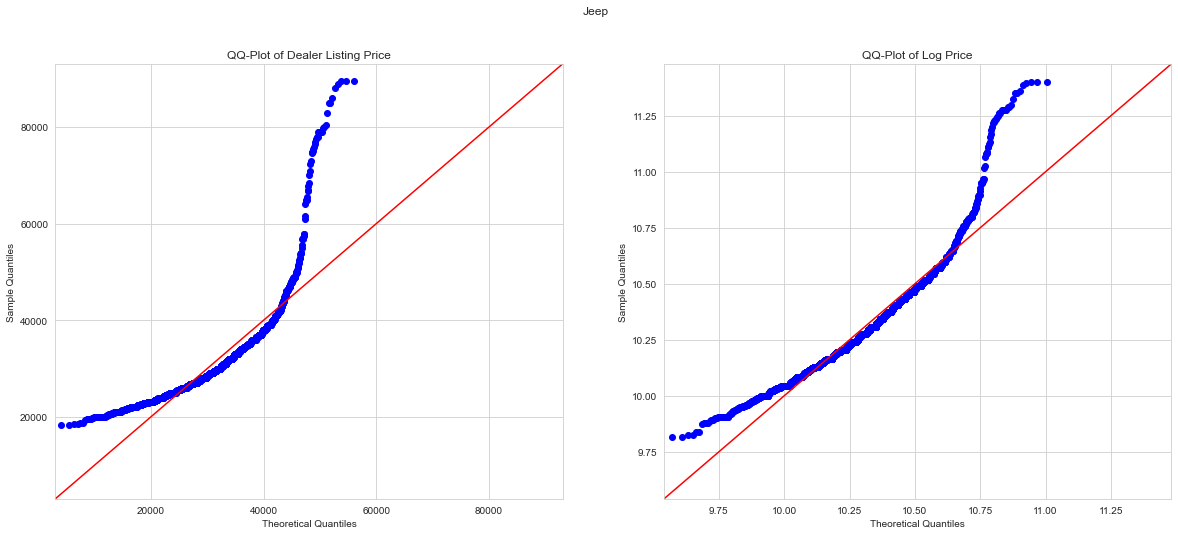

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
sm.qqplot(Jeep['dealer_listing_price'],
           loc=Jeep['dealer_listing_price'].mean(),
           scale=Jeep['dealer_listing_price'].std(),
           ax=axes[0], line='45')
axes[0].set_title('QQ-Plot of Dealer Listing Price')

temp=np.log(Jeep['dealer_listing_price'])
sm.qqplot(temp,
         loc=temp.mean(),
         scale=temp.std(),
         ax=axes[1], line='45')
axes[1].set_title('QQ-Plot of Log Price')
fig.suptitle('Jeep')

### Transform number into Z Score, then divides by Standard Deviation...attempting to standardize the data


In [41]:
def quick_scale(series):
    return series.sub(np.mean(series)).div(np.std(series))

Text(0.5, 1.0, 'Distribution of Scaled Log-Prices')

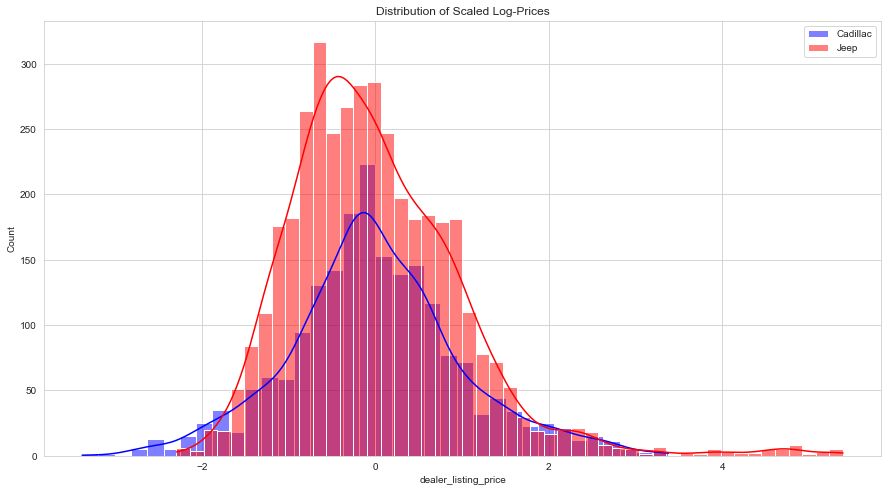

In [42]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(quick_scale(np.log(Cadillac['dealer_listing_price'])), kde=True, color='blue',ax=ax, label='Cadillac')
sns.histplot(quick_scale(np.log(Jeep['dealer_listing_price'])), kde=True, color='red',ax=ax, label='Jeep')
ax.legend()
ax.set_title('Distribution of Scaled Log-Prices')

Text(0.5, 0.98, 'Jeep')

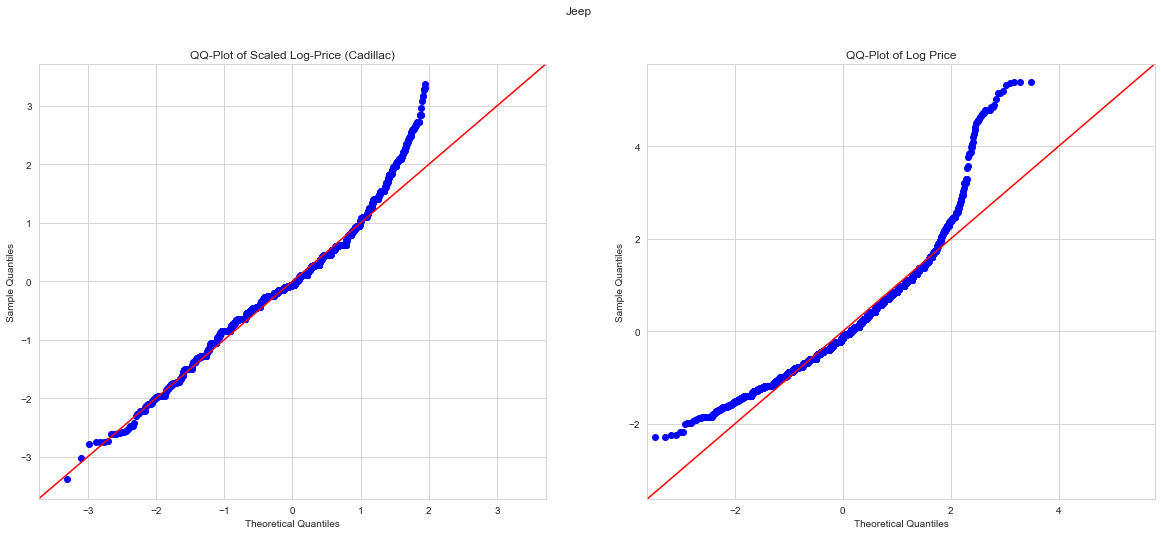

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
temp = quick_scale(np.log(Cadillac['dealer_listing_price']))
sm.qqplot(temp, line='45',ax=axes[0])
axes[0].set_title('QQ-Plot of Scaled Log-Price (Cadillac)')

temp=quick_scale(np.log(Jeep['dealer_listing_price']))
sm.qqplot(temp,ax=axes[1], line='45')
axes[1].set_title('QQ-Plot of Log Price')
fig.suptitle('Jeep')

In [44]:
Cadillac.loc[:, 'log_price'] = np.log(Cadillac.loc[:, 'dealer_listing_price'])
Jeep.loc[:, 'log_price']=np.log(Jeep.loc[:, 'dealer_listing_price'])

In [45]:
whole_data = pd.concat([Jeep,Cadillac])
whole_data.dropna(inplace=True)
whole_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4965 entries, 4777 to 8617378
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            4965 non-null   object 
 1   sellerispriv          4965 non-null   bool   
 2   sellerlistsrc         4965 non-null   object 
 3   sellername            4965 non-null   object 
 4   sellerrating          4965 non-null   float64
 5   sellerrevcnt          4965 non-null   int64  
 6   sellerstate           4965 non-null   object 
 7   sellerzip             4965 non-null   float64
 8   vehbodystyle          4965 non-null   object 
 9   vehcertified          4965 non-null   bool   
 10  vehcolorext           4965 non-null   object 
 11  vehcolorint           4965 non-null   object 
 12  vehdrivetrain         4965 non-null   object 
 13  vehengine             4965 non-null   object 
 14  vehfeats              4965 non-null   object 
 15  vehfuel        

## Thresholding Values in Columns by Counts

In [46]:
test_index = np.random.choice(whole_data.index,
                             size=whole_data.index.size // 5,
                             replace=False)
train_index = whole_data.index[[i not in test_index for i in whole_data.index]]
whole_data, test_data = whole_data.loc[train_index,:].copy(), whole_data.loc[test_index,:].copy()

In [47]:
categorical_features = []
numeric_features = []
drop_features=[]
data_cols=whole_data.columns[:26]
data_cols

Index(['sellercity', 'sellerispriv', 'sellerlistsrc', 'sellername',
       'sellerrating', 'sellerrevcnt', 'sellerstate', 'sellerzip',
       'vehbodystyle', 'vehcertified', 'vehcolorext', 'vehcolorint',
       'vehdrivetrain', 'vehengine', 'vehfeats', 'vehfuel', 'vehhistory',
       'vehlistdays', 'vehmake', 'vehmileage', 'vehmodel', 'vehpricelabel',
       'vehsellernotes', 'vehtype', 'vehtransmission', 'vehyear'],
      dtype='object')

In [48]:
i = 0
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777       Waukesha
10882         Olean
12013        Ottawa
12334      Elmhurst
13173    Louisville
Name: sellercity, dtype: object

In [49]:
(temp.value_counts() / temp.size).head(10)

Chicago         0.022407
Battle Creek    0.021652
Columbus        0.012085
Louisville      0.010574
Atlanta         0.009567
Dallas          0.008308
Houston         0.008308
Raleigh         0.008056
Cincinnati      0.007805
Milwaukee       0.006546
Name: sellercity, dtype: float64

In [50]:
# delete the city column, too many categories to add value to our analysis.
drop_features.append(data_cols[i])
i += 1

In [51]:
temp = whole_data[data_cols[i]].copy()
temp.head(), temp.value_counts()

(ListingID
 4777     False
 10882    False
 12013    False
 12334    False
 13173    False
 Name: sellerispriv, dtype: bool,
 False    3972
 Name: sellerispriv, dtype: int64)

In [52]:
# too imbalanced to be worth keeping
drop_features.append(data_cols[i])
i += 1

### The Functions below were added retrospectively, after defining what parsing/changes to the data needed to be made.

In [53]:
def bin_sellerlistsrc(series):
    series.loc[series.isna()]='other'
    
    series=series.str.lower()
    series.loc[series.str.contains('digital')] = 'dmi'
    series.loc[series.str.contains('command')] = 'icc'
    series.loc[series.str.contains('home')] = 'homenet'
    series.loc[series.str.contains('certified')] = 'certified'
    series.loc[(series != 'dmi') & (series != 'icc') & (series != 'homenet') & (series != 'certified')] = 'other'
    return series

In [54]:
def bin_vehcolorext(series):
    series.loc[series.isna()]='other'
    
    series=series.str.lower()
    series.loc[series.str.contains('pearl')] = 'pearl'
    series.loc[series.str.contains('metallic')] = 'metallic'
    series.loc[series.str.contains('clear')] = 'clear'
    series.loc[series.str.contains('certified')] = 'certified'
    series.loc[(series != 'pearl') & (series != 'metallic') & (series != 'clear')] = 'other'
    return series

In [55]:
def bin_vehcolorint(series):
    keep_colors = ['black','unknown','beige','frost','cirrus','brown','tan','maple','red','plum']
    series.loc[series.isna()]='unknown'
    
    series = series.str.lower()
    for color in keep_colors:
        series.loc[series.str.contains(color)]=color
    
    series.loc[series.isin(keep_colors) == False] ='other'
    return series

In [56]:
def bin_vehdrivetrain(series):
    
    series.loc[series.isna()]='unknown'
    series = series.str.lower()    
    series.loc[series.str.contains('a')] = 'awd'
    series.loc[series.str.contains('front')] = 'fwd'
    series.loc[series.str.contains('4')] = '4wd'
    series.loc[series.str.contains('four')] = '4wd'
       
    series.loc[(series != 'awd')&(series != 'fwd')&(series != '4wd')] ='unknown'
    return series

In [57]:
def bin_vehengine(series):
    
    series.loc[series.isna()]='other'
    series = series.str.lower()
    keep_engines = ['3.6','5.7','6.2','6.4','3.0','8']
    
    for eng in keep_engines:
        series.loc[series.str.contains(eng)]=eng
    series.loc[series.str.contains('hemi')] = '8'
    series.loc[series.isin(keep_engines)==False]='other'
    return series    
        

In [58]:
def process_vehfeats(series):
    keep_cols = ['brake','airbag','input','security','audio','camera','bluetooth','alloy','umin','fm','cond','seat']
    
    series.loc[series.isna()] ="'none'"
    for j in range(len(series)):
        series.iloc[j] = sorted(index=series.index, columns=keep_cols)
        
    vehfeats_df = pd.DataFrame(series.to_list(), index=series.index)
    onehot_vehfeats = pd.DataFrame(index=series.index, columns=Keep_cols)
                                  
    for col in oneshot_vehfeats.columns:
        for idx in onehot_vehfeats.index:
            tempsum = vehseats_df.loc[idx, :].str.lower().str.contains(col).sum()
            if col == 'brake':
                tempsum += vehfeats_df.loc[idx, :].str.lower().str.contains('abs').sum()
            if col == 'security':
                tempsum += vehfeats_df.loc[idx, :].str.lower().str.contains('alarm').sum()
            onehot_vehfeats.loc[idx, col] = tempsum > 0
    onehot_vehfeats = onehot_vehfeats.astype(int)
    return onehot_vehfeats

In [59]:
def process_vehhistory(series):
    series.loc[series.isna()]='none'
    
    for j in series.index:
        series.loc[j] = series.loc[series.loc[j].split(',')
                   
    series_df = pd.DataFrame(series.to_list(), index=series.index)
    for col in series_df.columns:
        series_df.loc[series_df[col].isna(), col] = 'none'
                   
    output_df = pd.DataFrame(index=series.index)
    output_df['owners']=pd.Series([j[0] for j in series_df.loc[:, 0]], index=series_df.index)
    output_df.loc[output_df['owners']=='n', 'owners'] =np.nan
    
    output_df['accidents'] = 0
    output_df.loc[series_df.loc[:, 1].str.lower().str.contains('acc'), 'accidents'] = 1
    
    output_df['use'] = 'none'
    output_df.loc[series_df.loc[:,1].str.lower().str.contains('use'), 'use'] = series_df.loc[series_df.loc[:,1].str.lower().str.contains('use'), 1]
    output_df.loc[series_df.loc[:,2].str.lower().str.contains('use'), 'use'] = series_df.loc[series_df.loc[:,2].str.lower().str.contains('use'), 2]
    output_df.loc[output_df['use'] != 'none'] = 1
    output_df.loc[output_df['use'] == 'none'] = 0
                   
    output_df['title'] = 0
    output_df.loc[series_df.loc[:,1].str.lower().str.contains('tit'), 'title'] = series_df.loc[series_df.loc[:,1].str.lower().str.contains('tit'), 1]
    output_df.loc[series_df.loc[:,2].str.lower().str.contains('tit'), 'title'] = series_df.loc[series_df.loc[:,2].str.lower().str.contains('tit'), 2]
    output_df.loc[series_df.loc[:,3].str.lower().str.contains('tit'), 'title'] = series_df.loc[series_df.loc[:,3].str.lower().str.contains('tit'), 3]
    output_df.loc[output_df['title'] != 0] = 1
                   
    output_df['buyback'] = 0
    for col in series_df.columns:
        output_df.loc[series_df.loc[:,col].str.lower().str.contains('buy'), 'buyback'] = series_df.loc[:,col].str.lower().str.contains('buy'), col]
    output_df.loc[output_df['buyback'] != 0] = 1
    
    return output_df['owners'], output_df.drop('owners', axis=1)

SyntaxError: invalid syntax (<ipython-input-59-035c4c88f03b>, line 7)

In [108]:
def process_vehsellernotes(series):
    series.loc[series.isna()] = 'none'
    tfidf = TfidfVectorizer(max_features=100)
    tfidf_data = tfidf.fit_transform(series)
    
    return tfidf_data, tfidf

In [109]:
def catfeats(catfeats):
    for feat in catfeats.columns:
        if catefeats.loc[:, feat].dtype != 'O':
            catfeats.loc[:,feat] = catfeats.loc[:,feat].astype('O')
            
    encoder = OneHotEncoder(handle_unknown='ignore')
    cats_encoded = encoder.fit_transform(catfeats)
##    cats_encoded = pd.DataFrame(cats_encoded.todense(), index, columns=[item for sublist in endcoder.categories_ for item in sum])

In [110]:
def process_numfeats(numfeats):
    scaler = StandardScaler()
    nums_scaled = scaler.fit_transform(numfeats)
    nums_sclaed = pd.DataFrame(nums_scaled, columns=numfeats.columns, index=numfeats.index)
    return scaler, nums_scaled

In [111]:
def process_tfidf(tfidf_data, tfidf, idx):
    tfidf_df = pd.DataFrame(tfidf_data.toarray(), index=idx, columns=tfidf.vocabulary_)
    return tfidf_df

In [113]:
def preprocess_features(features, dataset='train'):
    log_features = ['sellerrevcnt', 'vehlistdays']
    numeric_features = ['sellerrating','sellerrevcnt_log','vehlistdays','vehlistdays_log','vehmileage']
    categorical_features = ['sellerlistsrc','sellerrating_round','sellerstate','vehcertified','vehcolorext','vehcolorint','vehdrivetrain']
    drop_features = ['sellercity','sellerispriv','sellername','sellerzip','vehbodystyle','vehmodel','vehtype','vehtransmission']
    
    # Drop the features we don't want
    features = features.drop(drop_features, axis=1)
    
    # process each column
    features['sellerlistsrc'] = bin_sellerlistsrc(features['sellerlistsrc'])
    features['vehcolorext'] = bin_vehcolorext(features['vehcolorext'])
    features['vehcolorint'] = bin_vehcolorint(features['vehcolorint'])
    features['vehdrivetrain'] = bin_vehdrivetrain(features['vehdrivetrain'])
    features['vehengine'] = bin_vehengine(features['vehengine'])
    
    vehfeats_df = process_vehfeats(features['vehfeats']) #join this DF to the other features later
    features = features.drop('vehfeats', axis=1)
    
    owners, vehhistory_df = process_vehhistory(features['vehhistory'])
    features = features.drop('vehhistory', axis=1)
    
    tfidf_data, tfidf = process_vehsellernotes(features['vehsellernotes'])
    
    numfeats = features.loc[:, [j for j in features.columns if j in numeric_features]]
    for feat in log_features:
        
        ##This is actually an inverse hyperbolid sine transformation, which is defined for non-positive values
        numfeats[feat + '_log'] = np.log(features.loc[:, feat].add(features.loc[:, feat].pow(2).add(1).pow(.05)))
    
    catfeats = features.loc[:, [j for j in features.columns if j in categorical_features]]
    catfeats['sellerrating_round'] = features['sellerrating'].copy().round()
    catfeats['owners']=owners
                                        
    if datasets == 'test':
        return numfeats, catfeats, tfidf_data
    
    scaler, nums_scaled = process_numfeats(numfeats)
    encoder, cats_coded = process_catfeats(catfeats)
    tfidf_df = process_tfidf(tfidf_data, tfidf, numfeats.index)
    
    processed_features = pd.concat([num_scaled, cats_coded, vehfeats_df, tfidf_df], axis =1)
                                         
    return scaler, encoder, tfidf, processed_features
                                         
    

### Above: 

### All of the functions are meant to process the training set

### Below:

### The functions are meant to process the test set
They are mostly the same except that we use the scaler and encoder and tfidf from before

In [ ]:
def process_testFeatures(scaler, encoder, tfidf, features):
    log_features = ['sellerrevcnt', 'vehlistdays']
    numeric_features = ['sellerrating','sellerrevcnt_log','vehlistdays','vehlistdays_log','vehmileage']
    categorical_features = ['sellerlistsrc','sellerrating_round','sellerstate','vehcertified','vehcolorext','vehcolorint','vehdrivetrain']
    drop_features = ['sellercity','sellerispriv','sellername','sellerzip','vehbodystyle','vehmodel','vehtype','vehtransmission']
    
    # Drop the features we don't want
    features = features.drop(drop_features, axis=1)
    
    # process each column
    features['sellerlistsrc'] = bin_sellerlistsrc(features['sellerlistsrc'])
    features['vehcolorext'] = bin_vehcolorext(features['vehcolorext'])
    features['vehcolorint'] = bin_vehcolorint(features['vehcolorint'])
    features['vehdrivetrain'] = bin_vehdrivetrain(features['vehdrivetrain'])
    features['vehengine'] = bin_vehengine(features['vehengine'])
    
    vehfeats_df = process_vehfeats(features['vehfeats']) #join this DF to the other features later
    features = features.drop('vehfeats', axis=1)
    
    owners, vehhistory_df = process_vehhistory(features['vehhistory'])
    features = features.drop('vehhistory', axis=1)
    
    tfidf_data = process_vehsellernotes(features['vehsellernotes'], tfidf)
    
    numfeats = features.loc[:, [j for j in features.columns if j in numeric_features]]
    for feat in log_features:
        
        ##This is actually an inverse hyperbolid sine transformation, which is defined for non-positive values
        numfeats[feat + '_log'] = np.log(features.loc[:, feat].add(features.loc[:, feat].pow(2).add(1).pow(.05)))
    
    catfeats = features.loc[:, [j for j in features.columns if j in categorical_features]]
    catfeats['sellerrating_round'] = features['sellerrating'].copy().round()
    catfeats['owners']=owners
                                        
    if datasets == 'test':
        return numfeats, catfeats, tfidf_data
    
    scaler, nums_scaled = process_numfeats(numfeats)
    encoder, cats_coded = process_catfeats(catfeats)
    tfidf_df = process_tfidf(tfidf_data, tfidf, numfeats.index)
    
    processed_features = pd.concat([num_scaled, cats_coded, vehfeats_df, tfidf_df], axis =1)
                                         
    return scaler, encoder, tfidf, processed_features
                                         
    

In [65]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777       Jeep Certified Program
10882    Digital Motorworks (DMi)
12013    Digital Motorworks (DMi)
12334    Digital Motorworks (DMi)
13173    Digital Motorworks (DMi)
Name: sellerlistsrc, dtype: object

In [66]:
temp.value_counts() / temp.size

Digital Motorworks (DMi)    0.541541
Inventory Command Center    0.187311
HomeNet Automotive          0.172205
Jeep Certified Program      0.094663
My Dealer Center            0.004280
Name: sellerlistsrc, dtype: float64

In [68]:
temp = bin_sellerlistsrc(temp)
temp.value_counts() / temp.size

dmi          0.541541
icc          0.187311
homenet      0.172205
certified    0.094663
other        0.004280
Name: sellerlistsrc, dtype: float64

In [69]:
# save this in the list of categorical features
categorical_features.append(data_cols[i])
i += 1

In [70]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     Wilde Chrysler Jeep Dodge Ram &amp; Subaru
10882        Paul Brown Chrysler Dodge Jeep RAM Kia
12013                             Sierra Motor Mall
12334          Larry Roesch Dodge Chrysler Jeep RAM
13173                      Cross Chrysler Jeep Fiat
Name: sellername, dtype: object

In [71]:
temp.value_counts() / temp.size

Vroom (Online Dealer - Nationwide Delivery)    0.060423
Carvana                                        0.051611
Henkel Chrysler Dodge Jeep Ram                 0.021148
Sewell Cadillac of Dallas                      0.007301
Marino Chrysler Jeep Dodge RAM                 0.006798
                                                 ...   
BMW of Las Vegas                               0.000252
Mercedes-Benz of Gainesville                   0.000252
Greg Hubler Ford/Hyundai                       0.000252
CarMax Tulsa                                   0.000252
DeSmet Auto Sales                              0.000252
Name: sellername, Length: 1696, dtype: float64

In [72]:
drop_features.append(data_cols[i])
i += 1

In [73]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     4.8
10882    3.0
12013    3.5
12334    4.6
13173    4.8
Name: sellerrating, dtype: float64

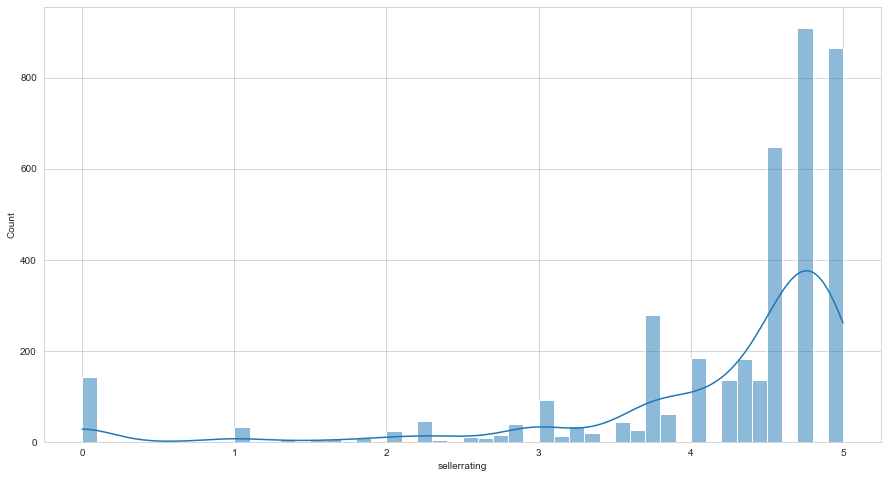

In [74]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(temp, kde=True, ax=ax);

In [75]:
#bin this one by rounding, but also keep the original as numeric
categorical_features.append(data_cols[i] + '_round')
numeric_features.append(data_cols[i])
i += 1

In [76]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     1405
10882      51
12013      17
12334     240
13173     774
Name: sellerrevcnt, dtype: int64

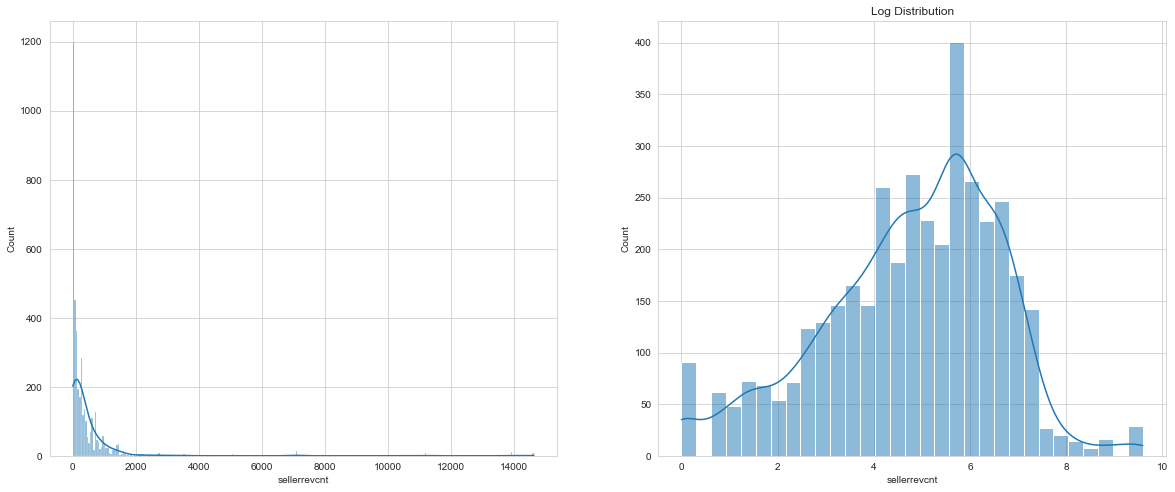

In [77]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
sns.histplot(temp, kde=True, ax=axes[0])
axes[1].set_title('Original Distribution')

sns.histplot(np.log(temp), kde=True, ax=axes[1])
axes[1].set_title('Log Distribution');

In [78]:
# do a log transform and keep numeric
numeric_features.append(data_cols[i]+ '_log')
i+= 1

In [79]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     WI
10882    NY
12013    IL
12334    IL
13173    KY
Name: sellerstate, dtype: object

In [80]:
temp.value_counts().head(5).append(temp.value_counts().tail(5))

IL    484
MI    387
OH    386
WI    290
PA    213
VT      2
RI      2
MT      1
HI      1
ND      1
Name: sellerstate, dtype: int64

In [81]:
# keep all of these, we will one-hot encode them and then select features later
categorical_features.append(data_cols[i])
i+= 1

In [82]:
temp=whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     53186.0
10882    14760.0
12013    61350.0
12334    60126.0
13173    40218.0
Name: sellerzip, dtype: float64

In [83]:
temp.unique().size

1370

In [84]:
# drop this feature.  Too complex to work with.
#If I could bring in new data, I would like to chaneg these to coordinates,
# then see if we could use the numeric coordinates data to find centers where prices/packages differ
drop_features.append(data_cols[i])
i += 1

In [85]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     SUV
10882    SUV
12013    SUV
12334    SUV
13173    SUV
Name: vehbodystyle, dtype: object

In [86]:
temp.value_counts()

SUV    3972
Name: vehbodystyle, dtype: int64

In [87]:
#All of these are SUVs...Drop this column
drop_features.append(data_cols[i])
i += 1

In [88]:
temp=whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777      True
10882    False
12013    False
12334    False
13173    False
Name: vehcertified, dtype: bool

In [89]:
temp.value_counts()

False    3258
True      714
Name: vehcertified, dtype: int64

In [90]:
#keep as categorical
categorical_features.append(data_cols[i])
i += 1

In [91]:
temp=whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     Brilliant Black Crystal Pearlcoat
10882     Billet Silver Metallic Clearcoat
12013                  True Blue Pearlcoat
12334                                  Red
13173               Bright White Clearcoat
Name: vehcolorext, dtype: object

In [92]:
temp=bin_vehcolorext(temp)
temp.value_counts()

metallic    1449
other       1412
pearl        689
clear        422
Name: vehcolorext, dtype: int64

In [93]:
#Categorical Feature!
categorical_features.append(data_cols[i])
i += 1

In [94]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     Black
10882    Black
12013    Black
12334    Black
13173    Black
Name: vehcolorint, dtype: object

In [95]:
temp.value_counts()

Black                                                 2147
Jet Black                                              601
Shara Beige                                            204
Sahara Beige                                           118
Cirrus                                                 106
                                                      ... 
Red/Black                                                1
Black/Lt. Frost Beige                                    1
Jet Black w/Leather Seating Surfaces w/Mini Perfor       1
Jet Black W/Leather Seating Surfaces W/Mini Perfor       1
Pewter                                                   1
Name: vehcolorint, Length: 84, dtype: int64

In [96]:
temp = bin_vehcolorint(temp)
temp.value_counts()

black     3127
beige      361
frost      117
cirrus     110
brown       62
maple       54
other       52
tan         41
red         37
plum        11
Name: vehcolorint, dtype: int64

In [97]:
#bin this one, then keep as categorical variable
categorical_features.append(data_cols[i])
i += 1

In [98]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     4x4/4WD
10882        4WD
12013        4WD
12334        4WD
13173        4WD
Name: vehdrivetrain, dtype: object

In [99]:
temp = bin_vehdrivetrain(temp)
temp.value_counts()

4wd    2696
fwd     750
awd     526
Name: vehdrivetrain, dtype: int64

In [100]:
categorical_features.append(data_cols[i])
i += 1

In [101]:
temp = whole_data[data_cols[i]].copy()

In [102]:
temp = bin_vehengine(temp)
temp.value_counts()

3.6      3621
5.7       155
other     101
6.4        48
6.2        30
3.0        12
8           5
Name: vehengine, dtype: int64

In [103]:
#keep as categorical
categorical_features.append(data_cols[i]) 
i+= 1

### Vehfeats Column

For the next colum, we've written a function that takes the string, turns it into a list, used that series of lists to creat a DF with one entry in each column, then uses that DF to make another DF which one-hot encodes whether certain "important" words appear in a row.  Thus, we can easily one-hot encode whether, for example, a security system is listed in vegicle features.

In [104]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     ['18 WHEEL &amp; 8.4 RADIO GROUP-inc: Nav-Capa...
10882    ['1st and 2nd row curtain head airbags', '4-wh...
12013    ['1st and 2nd row curtain head airbags', '4-wh...
12334    ['1st and 2nd row curtain head airbags', '4-wh...
13173    ['1st and 2nd row curtain head airbags', '4-wh...
Name: vehfeats, dtype: object

In [105]:
temp2 = process_vehfeats(temp)

TypeError: sorted expected 1 arguments, got 0

In [106]:
temp2.head()

NameError: name 'temp2' is not defined

temp2.mean()

i += 1
temp = whole_data[data_cols{i]].copy()
temp.head()

In [114]:
temp.value_counts()

['1st and 2nd row curtain head airbags', '4-wheel ABS Brakes', 'ABS and Driveline Traction Control', 'Anti-theft alarm system', 'Audio controls on steering wheel', 'Audio system memory card slot', 'Auxilliary engine cooler', 'Braking Assist']                                     564
['1st and 2nd row curtain head airbags', '4-wheel ABS Brakes', 'ABS and Driveline Traction Control', 'AM/FM/Satellite-prep Radio', 'Audio controls on steering wheel', 'Audio system memory card slot', 'Automatic front air conditioning', 'Auxilliary engine cooler']                426
['1st and 2nd row curtain head airbags', '4-wheel ABS Brakes', 'ABS and Driveline Traction Control', 'Anti-theft alarm system', 'Audio controls on steering wheel', 'Auxilliary engine cooler', 'Braking Assist', 'Bucket front seats']                                                208
['1st and 2nd row curtain head airbags', '4-wheel ABS Brakes', 'ABS and Driveline Traction Control', 'Aluminum door trim', 'Audio controls on steering 

In [115]:
#keep as cateogircal variable
categorical_features.append(data_cols[i])
temp.head()

ListingID
4777     ['18 WHEEL &amp; 8.4 RADIO GROUP-inc: Nav-Capa...
10882    ['1st and 2nd row curtain head airbags', '4-wh...
12013    ['1st and 2nd row curtain head airbags', '4-wh...
12334    ['1st and 2nd row curtain head airbags', '4-wh...
13173    ['1st and 2nd row curtain head airbags', '4-wh...
Name: vehfeats, dtype: object

The first element in the list always contains the number of owners, unless the list is empty.  If accidents are resports, that goes int he second place, otherwise there is a missing place.  Then, the use list (personal or non-personal) comes next.  Finally, the car is either buyback eligible or not.  That's how we are going to make a new DataFrame.

In [116]:
temp2_cat, temp2_of = process_vehhistory(temp)

NameError: name 'process_vehhistory' is not defined

In [ ]:
temp2_cat.mean()

In [ ]:
temp2_oh.mean()

In [ ]:
i += 1
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
sns.histplot(temp, kde=True, ax=axes[0])
axes[1].set_title('Original Distribution')

sns.histplot(np.log(temp), kde=True, ax=axes[1])
axes[1].set_title('Log Distribution');

In [ ]:
# keep log distribution as numeric
numeric_features.append(data_cols[i])
numeric_features.append(data_cols[i] + '_log')

In [ ]:
i += 1
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
# keep as categorical (though we are likely to drop this one and make separate models for each make)
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
sns.histplot(temp, kde=True, ax=axes[0])
axes[0].set_title('Distribution')
sm.qqplot(temp,
         loc=temp.mean(),
         scale=temp.std(),
         line='45',
         ax=axes[1])
axes[1].set_title('QQ-Plot');

In [ ]:
# looks good.  This is a numeric feature
numeric_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp.value_counts()

In [ ]:
#same as vehmake. Just drop this column.
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp.value_counts()

In [ ]:
#already looks clean enough.  Categorical
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp.iloc[1]

This is text data.  It would take some serious NLP effort to get valuable insight out of this.  Lets drop the STOP works and do some TF-IDF and keep a few words that have decent mutual informantion with the dependent vairable.

In [ ]:
tfidf_data = process_vehsellers(temp)

In [ ]:
tfidf_data

In [ ]:
i += 1
temp=whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp.value_counts()

In [ ]:
#all the same.  drop this one.
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp.value_counts()

In [ ]:
#basically all version of automatic.  Drop this one.
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp.value_counts()

In [ ]:
# keep as categorical
categorical_features.append(data_cols[i])
i += 1

We have completed the parsing of each of the data into their respective lists.

In [ ]:
print(numeric_features)

In [ ]:
print(categorical_features)

In [ ]:
print(drop_features)

In [ ]:
whole_data.head()

## Final Pre-Processing

We have a function that preprocesses all the features.  The final steps are to scale (using Standard Scaler) and One-Hot Encoding (Using OneHotEncoder) the numerical/categorical features, then put it all together into one big dataframe.  Then, we can do some feature selection.

In [ ]:
features = whole_data.iloc[:, :-3]
target1 = whole_data['vehicle_trim']
target2 = whole_data['dealer_listing_price']
target3 = whole_data['log_price']

In [ ]:
scaler, encoder, tfidf, processed_features = preprocess_features(features)

In [ ]:
preprocessed_features.info()

## Feature Selection

In [ ]:
pca = PCA()
pca_features = pca.fit_transform(processed_features)

In [ ]:
explained_variance = pd.DataFrame(pca.explained_variance_ratio_)

In [ ]:
ninetyfive_p = ((explained_variance.cumsum() > 0.05).drop_duplicates().index[-1]

### Where the insection occurs accounts for how many features are required for 95% of the variance

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
explained_variance.cumsum().plot(ax=ax)
ax.set_title('Explained Variance (PCA)')
ax.axvline(ninetyfive_p, linestyle='dashed',c='black')
ax.axhline(0.95, linestyle='dashed', c='black');

In [ ]:
tsne = TSNE()
tsne_features = tsne.fit_transform(processed_features)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize(20,8))
sns.scatterplot(x=pca_features[:,0], y=pca_features)[;,1], hue=target1, ax=axes[0])
axes[0].set_title('t-SNE')

fig.suptitle('2D Seraration')
sns.despine()
plt.tight_layout();

In [ ]:
mutual_info = mutual_info_regression(processed_features, target2)
mutual_info = pd.Series(mutual_info, index=processed)features.columns)

In [ ]:
fig, axes = plt.subplots(ncols = 2, figsize(20,8))
mutual_info.sort_values().tail(10).plot.barh(ax=axes[0])
axes.[0].set_xlim(0,1)
fig.suptitle('Most Important Features by Mutual Information');

We are going to start off by just including all of our features and see how that goes

### Modelling Trim

In [ ]:
trim_encoder = LabelEncoder()
target1_coded = trim_encoder.fit_transform(target.values)

In [ ]:
cv = KFold(shuffle=True, random_state=1).split(processed_features.values, target1_coded)

roc_scores = dict()
preds = dict()
preds_proba = dict()
test_Xs = dict()
test_Ys = dict()

for i, (train_index, test_index) in enumerate(cv):
    X_train = processed_features.values[train_index]
    Y_train = target1_coded[train_index]
    
    text_Xs[i] = processed_features.values[test_index]
    test_Ys[i] = target1_coded[test_index]
    
    model = XGBClassifier(use_label_encoder=False, eval_metric='merror')
    fit_model=model.fit(X_train, Y_train)
    
    preds[i] = fit_model.predict(test_Xs[i])
    preds_proba[i] = roc_auc_score(test_Ys[i], pred_proba[i], multi_class='ovr') #one over rest

In [ ]:
[print(f'Fold {i}, AUC Score = {score}') for i, score in enumerate(roc_scores.values())];

In [117]:
def plot_multiclass_roc(n_classes, target_binarized, pred_proba, ax):
    false_positive_rate = dict()
    true_positive_rate = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        false_positive_rate[i], true_positive_rate[i], _ = roc_curve(target_binarized[:,i], pred_proba[:,i])
        roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])
        
        ax.plot(false_positive_rate[i], true_positive_rate[i], label=f'ROC Curve of Class {i} (AUC={roc_auc[i]:0.2f})')
    
    ax.plot([0,1], [0,1], 'k--')
    
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

In [ ]:
n_classes = target1.unique().size

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(21,24))
for split in preds_proba.keys():
    target_binarized = label_binarize(test_Ys[split], classes=range(n_classes))
    plot_multiclass_roc(n_classes, target_binarized, preds_proba[split], ax=axes[split])
fig.suptitle("ROC Curves")
plt.tight_layout();

#### Classification Reports

In [119]:
for i in preds.keys():
    print(f'SPLIT {i}')
    print(classification_report(test_Ys[i], preds[i]))
    print('\n')

NameError: name 'preds' is not defined

### Hyperparameter Tuning
The next step in predicting the trim is to tune the hyperparameters. I really would like to use the predicted trim to help predict the price, so we want our accuracy to be as high as possible.

#### Bayesian Hyperparamter Tuning using Hyperopt

In [ ]:
param_space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
              'gamma':hp.uniform("gamma", 1, 9),
               'reg_alpha':hp.quniform("reg_alpha", 40, 180, 1),
               'reg_lambda':hp.uniform("reg_lambda",0,1),
               'colsample_bytree': hp.quniform("colsample_bytree", 0.5, 1),
               'min_child_weight': hp.quinform("min_child_weight", 0,10,1),
               'n_estimators': hp.quniform("n_estimators", 100, 250, 1),
               'learning_rate': hp.uniform("learning_rate", 0, 0.1)}

In [122]:
def classification_tuning(hyperparameter_space):
    model = XGBClassifier(n_estimators=int(hyperparameter_space['n_estimators']),
        learning_rate=hyperparameter_space['learning_rate'],
        max_depth=int(hyperparameter_space['max_depth']),
        gamma=hyperparameter_space['gamma'],
        reg_alpha=int(hyperparameter_space['reg_alpha']),
        reg_lambda=hyperparameter_space['reg_lambda'],
        min_child_weight=hyperparameter_space['min_child_weight'],
        colsample_bytree=hyperparameter_space['colsample_bytree'],
        objective='multi:softprob',
        use_label_encoder=False)
    
    evaluation = [(X_train, Y_train), (X_test, Y_test)]
    
    model.fit(X_Train, Y_train,
             eval_set=evaluation,
             eval_metric='auc',
             early_stopping_rounds=20,
             verbose=False)
    
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)
    
    acc = accuracy_score(Y_test, pred)
    auc = roc_auc_score(Y_test, pred_proba, multi_class='ovr')
    
    print('Accuracy: {0: 2%}'.format(acc))
    print('AUC: {0:.2f}'.format(auc))
    
    return {'loss':-auc, 'status':STATUS_OK, 'model':model}

In [124]:
def regression_tuning(hyperparameter_space):
    model = XGBRegressor(n_estimators=int(hyperparameter_space['n_estimators']),
        learning_rate=hyperparameter_space['learning_rate'],
        max_depth=int(hyperparameter['max_depth']),
        gamma=hyperparameter_space['gamma'],
        reg_alpha=int(hyperparameter_space['reg_alpha']),
        reg_lambda=hyperparameter_space['reg_lambda'],
        min_child_weight=hyperparameter_space['min_child_weight'],
        colsample_bytree=hyperparameter_space['colsample_bytree'])
    
    evaluation = [(X_train, Y_train), (X_test, Y_test)]
    
    model.fit(X_Train, Y_Train,
             eval_set=evaluation,
             eval_metric='rmse',
             early_stopping_rounds=20,
             verbose=False)
    
    pred = model.predict(X_test)
    
    mse=mean_squared_error(Y_test, pred)
    r2=r2_score(Y_test, pred)
    
    print('RMSE: {0:.4f}'.format(mse**0.5))  # Root Mean Squared Error
    print('R2 : {0:.4f}'.format(r2))
    
    return {'loss': -r2, 'status':STATUS_OK, 'model':model}

In [123]:
def optimize(hyperparameter_space,
    features, target,
    regression=False):
    
    global X_train
    global X_test
    global Y_train
    global Y_test
    
    X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2)
    
    
    if regression == True:
        func = regression_tuning
    else:
        func = classification_tuning
        
    trials = Trials()
    best = fmin(fn=func,
               space=hyperparameter_space,
               algo=tpe.suggest,
               max_evals=100,
               trials=trials)
    
    return best

In [ ]:
best = optimize(param_space, 
               processed_features.values,
               target1_coded,
               regression=False)

In [ ]:
best

In [ ]:
model = XGBRegressor(n_estimators=int(best['n_estimators']),
                     learning_rate=best['learning_rate'],
                     gamma=best['gamma'],
                     reg_alpha=int(best['reg_alpha']),
                     reg_lambda=best['reg_lambda'],
                     max_depth=int(best['max_depth']),
                     min_child_weight=int(best['min_child_weight']),
                     colsample_bytree=best['colsample_bytree'])

In [ ]:
fit_model=model.fit(price_features.values, target2.values)

In [ ]:
training_pred = fit_model.predict(price_features)

fig, axes = plt.subplots(ncols=3, figsize=(21,5))
sns.scatterplot(x=target2.values, y=training_pred, ax=axes[0])
axes[0].plot([target2.min(), target2.max()], [training_pred.min(), training_pred.max()],
            c='red', linestyle='dashed')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')

res = training_pred - target2.values
sns.histplot(res, kde=True, ax=axes[1])
axes[1].set_xlabel('Residuals')

scores = dict(rmse = np.sqrt(mean_squared_error(target2.values, training_pred))),
              mae = mean_absolute_error(target2.values, training_pred),
              medae = median_absolute_error(target2.values, training_pred)
pd.Series(scores).plot.barh(ax=axes[2])

sns.despine()
fig.suptitle('Performance on Training Data');


In [ ]:
#feature_importance = pd.Series(fit_model.feature_inportances_, index=processed_features.columns).sort.values()

feature_importance = fit_model.feature_importances_
feature_importance = pd.Series(feature_importance, index-price_features.columns).sort_values()

fig, axes = plt.subplots(ncols=2, figsize=(20,8))
feature_importance.tail(10).plot.barh(ax=axes[0])
axes[0].set_xlim(0,0.1)
feature_importance.tail(20).iloc[:10].plot.barh(ax=axes[1])
#axes[1].set.xlim(0,0.1)
axes[1].set.xlim(0,.225)
#fig.suptitle('Feature Importance for Classification')
fig.suptitle('Important Features for Predicting Price')
sns.despine()
plt.tight_layout();

In [ ]:
training_trims_pred = pd.Seried(trim_encoder.inverse_transform(pred), index=target1.index)

### Predict Trim for Test Dataset

In [ ]:
#test_data = pd.read_csv("Test_DataSet.csv")
final_answers= test_data.iloc[:, -3:]
test_data = test_data.drop(final_answers.columns, axis=1)

In [ ]:
test_data.info()

In [ ]:
test_data.isna().sum()

In [ ]:
final_answers.info()

In [ ]:
test_features = process_testFeatures(scaler, encoder, tfidf, test_data)

In [ ]:
pred_labels_test = fit_model.predict(test_features.values)
pred_proba_test = pd.DataFrame(fit_model.predict_proba(test_features.values), index=test_features.index)
pred_trims_test=pd.Series(trim_encoder.inverse_transform(pred_labels_test), index=test_features.index)

#### Do the predicted trims make sense?

As a sanity check, let's see how different the proportion of predicted trims in the test set is from the proportion of actual trims from the training set.  If we are getting hude difference, e.g. 90% of test cars are SRT, then we really need to check the model and see what's going on.

In [ ]:
trim_proportions = pd.DataFrame({'training':target1.value_counts()target1.size,
                                'Testing':pred_trims_test.value_counts()/pred_trims_test.size})
trim_proportions = trim_proportions.fillna(0)
trim_proportions['Difference'] = abs(trim_proportions['Training'] - trim_proportions['Testing'])
trim_proportions.sort_values('Training', ascending=False)

The differences between the Training Set and the Testing set are at a minimum, which tells me that the model fits.  Using the Training Data to establish a model fitting, then applying it to the test data to ensure it's model accuracy....

### Modelling dealer_listing_price

In [ ]:
# add the trim to the processed features
onehot_trim = pd.get_dummies(target1)
price_features = pd.concat([processed_features, onehot_trim],axis=1)
price_features.info()

In [ ]:
cv = kFold(shuffle-True, random_state=20).split(price_features.values, target2.values)

r2_scores = dict()
scores_dict = dict()
preds = dict()
test_Xs = dict()
test_Ys = dict()

for i, (train_index, test_index) in enumerate(cv):
    X_train = price_features.values[train_index]
    Y_train = target2.values[train_index]
    
    text_Xs[i] = price_features.values[test_index]
    test_Ys[i] = target2.values[test_index]
    
    model = XGBRegressor()
    fit_model=model.fit(X_train, Y_train)
    
    preds[i] = fit_model.predict(test_Xs[i])
    rs_scores[i] = r2_score(test_Ys[i], preds[i])
    scores_dict[i] = {'rmse': np.sqrt(mean_squared_error(test_Ys[i], preds[i])),
                     'mae': mean_absolute_error(test_Ys[i], preds[i]),
                     'medae': median_absolute_error(test_Ys[i], preds[i])}

In [ ]:
[print(f'Fold {i}, Rs Score - {score}') for i, score in enumerate(r2_scores.values())];

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(21,24))

for split in r2_scores.keys():
    sns.scatterplot(x=test_Ys[split], y=preds[splits], ax=axes[split, 0])
    axes[split,0].plot([test_Ys[split}.min(), test_Ys[split].max()], [preds[split].min(), preds[split].max()],
                        c='red', linestyle='dashed')
    axes[split,0].set_xlabel('Listing Price')
    axes[split.0].set_ylabel('Predicted Price')
                        
    residuals = preds[split] - test_Ys[split]
    sns.histplot(residuals, ax=axes[split,1], kde=True)
    axes[split,1].set_xlabel('Residual')
                        
    pd.Series(scores_dict[split].plot.barh(ax=axes[split,2])
fig.suptitle('Validation Preformance by CV Split', fontsize=14)  ## CV = "Cross Validation"
sns.despine()
plt.tight_layout();

#### There a bit of a skew in the errors